In [191]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind  
import statsmodels.api as sm 
import numpy as np  

In [193]:
fear_df = pd.read_csv('fear_greed_index.csv')
fear_df['date'] = pd.to_datetime(fear_df['date'])  

hist_df = pd.read_csv('historical_data.csv', on_bad_lines='skip')  
hist_df['Timestamp IST'] = hist_df['Timestamp IST'].astype(str)  
hist_df['date'] = pd.to_datetime(hist_df['Timestamp IST'].str[:10], format='%d-%m-%Y')  

print("Fear & Greed Data (first 5 rows):")
print(fear_df.head())
print("\nHistorical Trade Data (first 5 rows):")
print(hist_df.head())
print("\nColumns in hist_df:", hist_df.columns)
print("\nData types in hist_df:\n", hist_df.dtypes)

Fear & Greed Data (first 5 rows):
    timestamp  value classification       date
0  1517463000     30           Fear 2018-02-01
1  1517549400     15   Extreme Fear 2018-02-02
2  1517635800     40           Fear 2018-02-03
3  1517722200     24   Extreme Fear 2018-02-04
4  1517808600     11   Extreme Fear 2018-02-05

Historical Trade Data (first 5 rows):
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.5

In [194]:
close_df = hist_df[hist_df['Closed PnL'] != 0]

In [195]:
daily_trades = close_df.groupby('date').agg({
    'Closed PnL': 'sum',      
    'Size USD': 'sum',        
    'Account': 'nunique'     
}).reset_index()

In [196]:
merged_df = pd.merge(daily_trades, fear_df[['date', 'value', 'classification']], on='date', how='inner')
print("\nMerged Data (first 5 rows):")
print(merged_df.head())


Merged Data (first 5 rows):
        date   Closed PnL  Size USD  Account  value classification
0 2023-12-14  -205.434737  76736.39        1     72          Greed
1 2023-12-15   -24.632034  10609.95        1     70          Greed
2 2023-12-17   304.982785  65965.81        1     73          Greed
3 2023-12-19  1000.538612  61883.49        1     73          Greed
4 2023-12-20   162.732282  70899.75        1     74          Greed


In [201]:
print("\nCorrelation Matrix:")
print(merged_df[['value', 'Closed PnL', 'Size USD']].corr())


Correlation Matrix:
               value  Closed PnL  Size USD
value       1.000000   -0.098367 -0.286776
Closed PnL -0.098367    1.000000  0.309377
Size USD   -0.286776    0.309377  1.000000


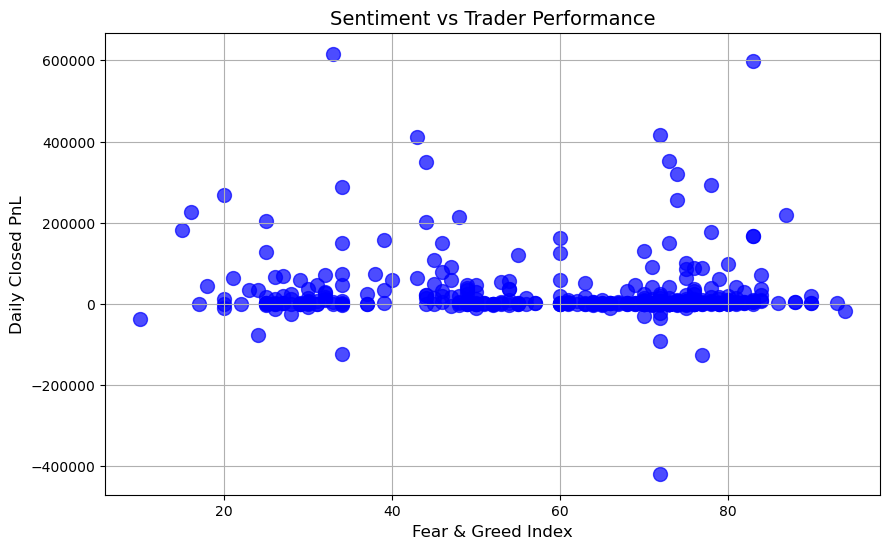

In [202]:
plt.figure(figsize=(10, 6))  
plt.scatter(merged_df['value'], merged_df['Closed PnL'], color='blue', s=100, alpha=0.7)  
plt.xlabel('Fear & Greed Index', fontsize=12)
plt.ylabel('Daily Closed PnL', fontsize=12)
plt.title('Sentiment vs Trader Performance', fontsize=14)
plt.grid(True)  
plt.show()

In [238]:
print("\nAverage PnL by Sentiment Classification:")
avg_pnl = merged_df.groupby('classification')['Closed PnL'].mean()
print(avg_pnl)

print("\nTotal PnL and Volume by Classification:")
summary_stats = merged_df.groupby('classification').agg({
    'Closed PnL': ['mean', 'sum', 'count'],  
    'Size USD': 'sum' 
})
print(summary_stats)


Average PnL by Sentiment Classification:
classification
Extreme Fear     52793.589178
Extreme Greed    25140.475099
Fear             44762.072555
Greed            12875.025587
Neutral          23507.648646
Name: Closed PnL, dtype: float64

Total PnL and Volume by Classification:
                  Closed PnL                          Size USD
                        mean           sum count           sum
classification                                                
Extreme Fear    52793.589178  7.391102e+05    14  5.689554e+07
Extreme Greed   25140.475099  2.715171e+06   108  5.796224e+07
Fear            44762.072555  3.357155e+06    75  2.396903e+08
Greed           12875.025587  2.150129e+06   167  1.369240e+08
Neutral         23507.648646  1.292921e+06    55  1.008995e+08


In [240]:
close_with_sentiment = pd.merge(close_df, fear_df[['date', 'value', 'classification']], on='date', how='inner')
print("\nAverage PnL by Account and Classification:")
print(close_with_sentiment.groupby(['Account', 'classification'])['Closed PnL'].mean())

print("\nAverage PnL by Coin and Classification:")
print(close_with_sentiment.groupby(['Coin', 'classification'])['Closed PnL'].mean())


Average PnL by Account and Classification:
Account                                     classification
0x083384f897ee0f19899168e3b1bec365f52a9012  Extreme Fear      3372.141120
                                            Extreme Greed     -163.749333
                                            Fear              1059.346858
                                            Greed             1808.622681
                                            Neutral            512.857619
                                                                 ...     
0xbee1707d6b44d4d52bfe19e41f8a828645437aab  Extreme Fear        10.692874
                                            Extreme Greed      105.931741
                                            Fear                 8.696411
                                            Greed               55.017973
                                            Neutral              6.317960
Name: Closed PnL, Length: 150, dtype: float64

Average PnL by Coin and Classificati

In [208]:
print("\nTrade Count by Side and Classification:")
trade_counts = hist_df.merge(fear_df[['date', 'classification']], on='date', how='inner').groupby(['Side', 'classification'])['Account'].count()
print(trade_counts)



Trade Count by Side and Classification:
Side  classification
BUY   Extreme Fear      10935
      Extreme Greed     17940
      Fear              30270
      Greed             24576
      Neutral           18969
SELL  Extreme Fear      10465
      Extreme Greed     22052
      Fear              31567
      Greed             25727
      Neutral           18717
Name: Account, dtype: int64


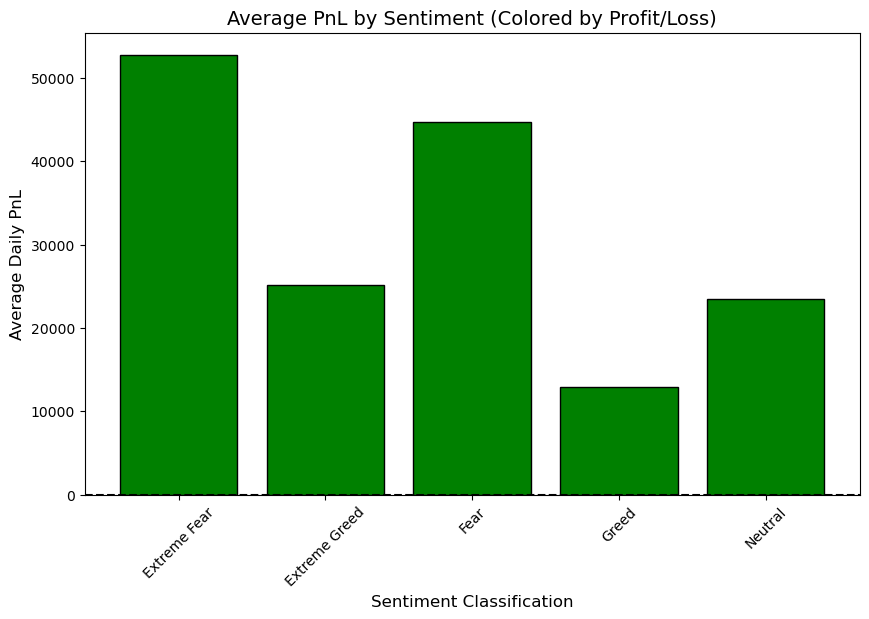

In [242]:
plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in avg_pnl.values]  
plt.bar(avg_pnl.index, avg_pnl.values, color=colors, edgecolor='black')
plt.xlabel('Sentiment Classification', fontsize=12)
plt.ylabel('Average Daily PnL', fontsize=12)
plt.title('Average PnL by Sentiment (Colored by Profit/Loss)', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(0, color='black', linestyle='--') 
plt.show()

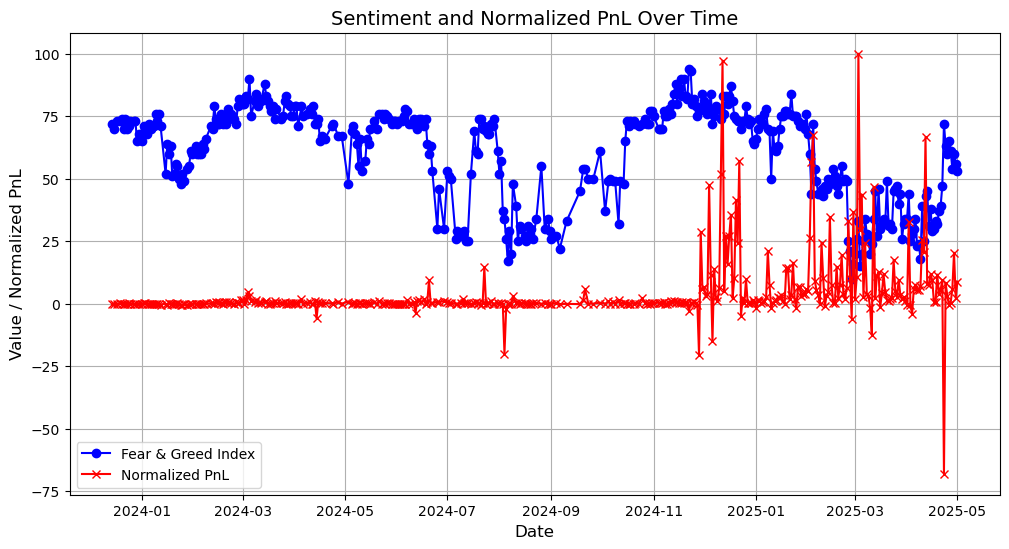

In [244]:
normalized_pnl = merged_df['Closed PnL'] / merged_df['Closed PnL'].abs().max() * 100  
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'], merged_df['value'], label='Fear & Greed Index', color='blue', marker='o')
plt.plot(merged_df['date'], normalized_pnl, label='Normalized PnL', color='red', marker='x')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value / Normalized PnL', fontsize=12)
plt.title('Sentiment and Normalized PnL Over Time', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

In [214]:
greed_pnl = merged_df[merged_df['classification'].str.contains('Greed', case=False)]['Closed PnL']  
extreme_greed_pnl = merged_df[merged_df['classification'].str.contains('Extreme Greed', case=False)]['Closed PnL']
if len(greed_pnl) > 1 and len(extreme_greed_pnl) > 1:  
    print("\nT-test (Greed vs Extreme Greed PnL):")
    t_stat, p_value = ttest_ind(greed_pnl, extreme_greed_pnl, equal_var=False)
    print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("Significant difference in PnL between Greed and Extreme Greed.")
    else:
        print("No significant difference.")
else:
    print("\nNot enough data for T-test in Greed or Extreme Greed.")


T-test (Greed vs Extreme Greed PnL):
T-statistic: -0.89, P-value: 0.3727
No significant difference.


In [216]:
X = merged_df[['value']]
X = sm.add_constant(X)  
y = merged_df['Closed PnL']
model = sm.OLS(y, X).fit()
print("\nLinear Regression Summary (Predicting PnL from Sentiment Value):")
print(model.summary())


Linear Regression Summary (Predicting PnL from Sentiment Value):
                            OLS Regression Results                            
Dep. Variable:             Closed PnL   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.074
Date:                Mon, 29 Sep 2025   Prob (F-statistic):             0.0442
Time:                        04:18:18   Log-Likelihood:                -5303.3
No. Observations:                 419   AIC:                         1.061e+04
Df Residuals:                     417   BIC:                         1.062e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

<Figure size 1000x600 with 0 Axes>

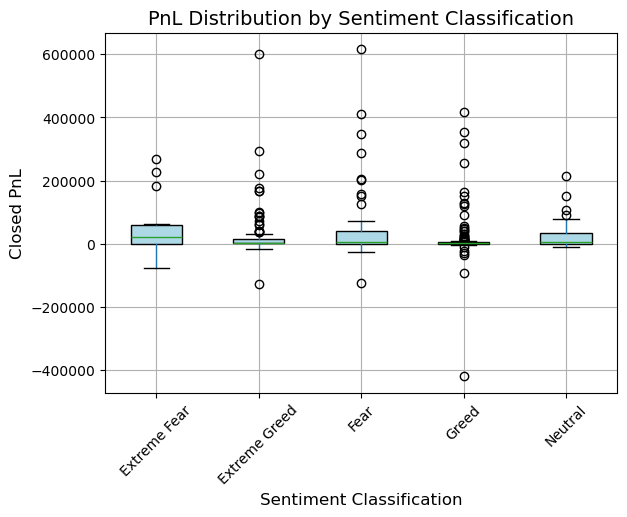

In [219]:
plt.figure(figsize=(10, 6))
merged_df.boxplot(column='Closed PnL', by='classification', grid=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('PnL Distribution by Sentiment Classification', fontsize=14)
plt.suptitle('')  # Remove default subtitle
plt.xlabel('Sentiment Classification', fontsize=12)
plt.ylabel('Closed PnL', fontsize=12)
plt.xticks(rotation=45)
plt.show()

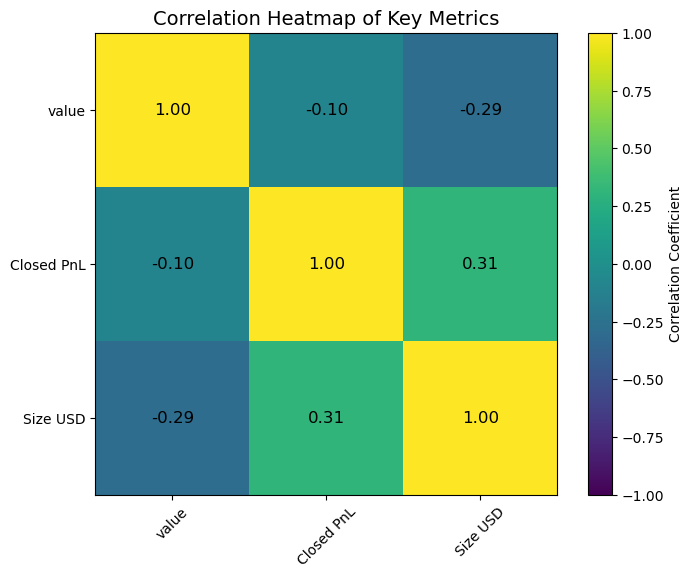

In [220]:
corr_matrix = merged_df[['value', 'Closed PnL', 'Size USD']].corr()
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, fontsize=10)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=10)
plt.title('Correlation Heatmap of Key Metrics', fontsize=14)
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black', fontsize=12)
plt.show()

In [222]:
merged_df['pnl_zscore'] = np.abs((merged_df['Closed PnL'] - merged_df['Closed PnL'].mean()) / merged_df['Closed PnL'].std())
outliers = merged_df[merged_df['pnl_zscore'] > 3]  
print("\nDetected Outliers in PnL (Z-score > 3):")
print(outliers[['date', 'Closed PnL', 'classification', 'pnl_zscore']])


Detected Outliers in PnL (Z-score > 3):
          date     Closed PnL classification  pnl_zscore
270 2024-12-04  292891.815021  Extreme Greed    3.511987
277 2024-12-11  319051.554217          Greed    3.854261
278 2024-12-12  599151.795008  Extreme Greed    7.519097
286 2024-12-20  254969.660039          Greed    3.015813
288 2024-12-22  352197.163973          Greed    4.287939
331 2025-02-03  348871.326269           Fear    4.244423
332 2025-02-04  416876.888120          Greed    5.134209
359 2025-03-03  616413.032233           Fear    7.744943
361 2025-03-05  269328.365917   Extreme Fear    3.203682
368 2025-03-12  288105.984215           Fear    3.449369
399 2025-04-12  410419.694533           Fear    5.049723
410 2025-04-23 -419020.225731          Greed    5.802682



Saved 'sentiment_vs_pnl.png'


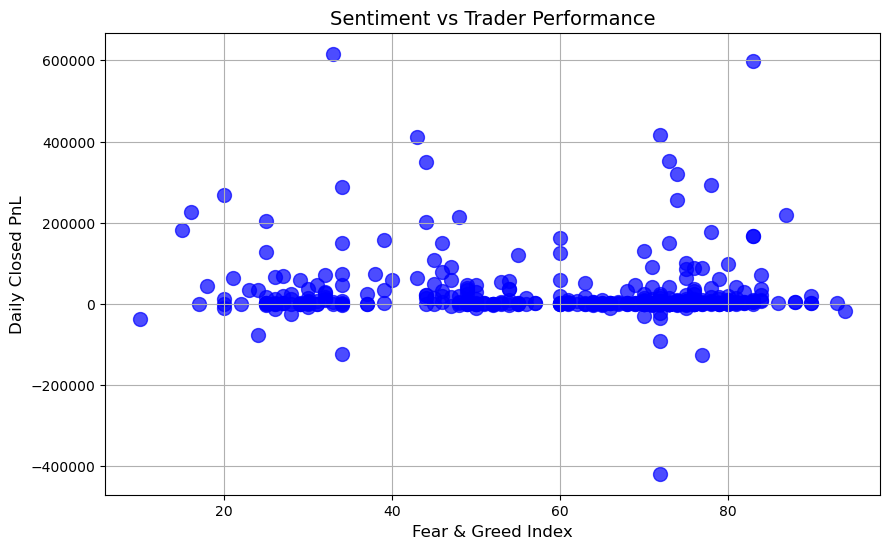

In [227]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['value'], merged_df['Closed PnL'], color='blue', s=100, alpha=0.7)
plt.xlabel('Fear & Greed Index', fontsize=12)
plt.ylabel('Daily Closed PnL', fontsize=12)
plt.title('Sentiment vs Trader Performance', fontsize=14)
plt.grid(True)
plt.savefig('sentiment_vs_pnl.png', dpi=300) 
print("\nSaved 'sentiment_vs_pnl.png'")

Saved 'avg_pnl_bar.png'


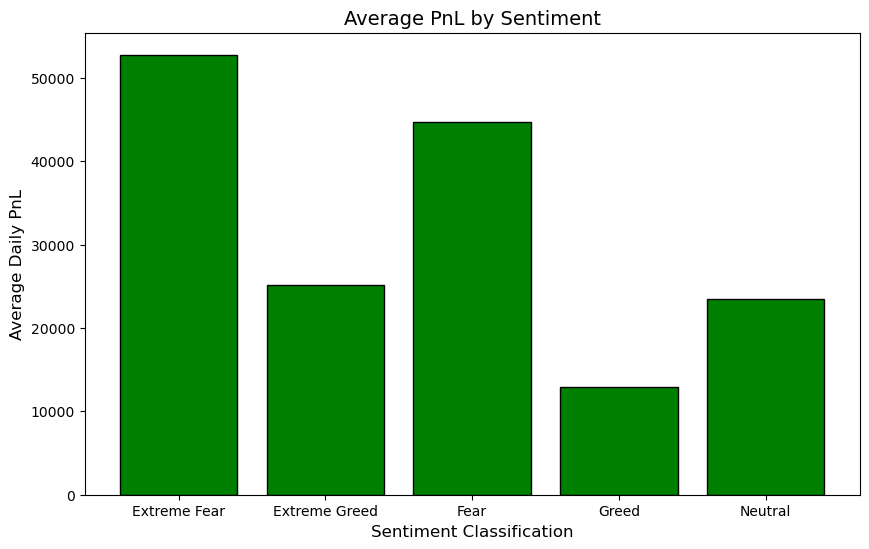

In [228]:
plt.figure(figsize=(10, 6))
plt.bar(avg_pnl.index, avg_pnl.values, color=colors, edgecolor='black')
plt.xlabel('Sentiment Classification', fontsize=12)
plt.ylabel('Average Daily PnL', fontsize=12)
plt.title('Average PnL by Sentiment', fontsize=14)
plt.savefig('avg_pnl_bar.png', dpi=300)
print("Saved 'avg_pnl_bar.png'")

Saved 'correlation_heatmap.png'


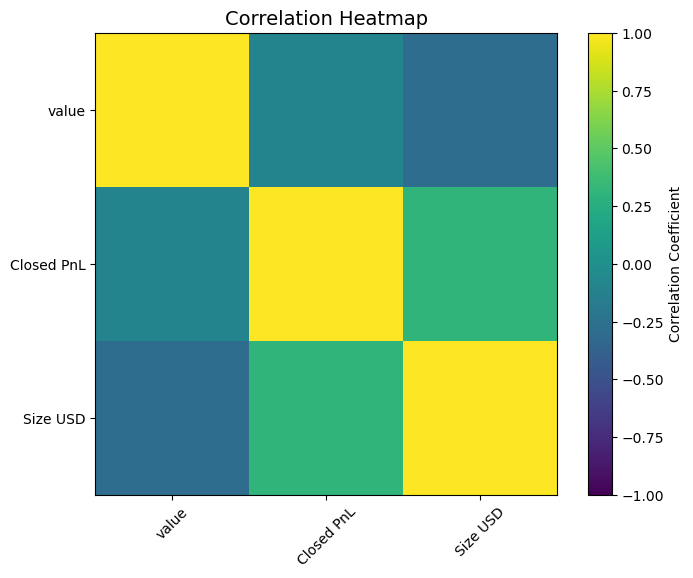

In [229]:
# Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Correlation Heatmap', fontsize=14)
plt.savefig('correlation_heatmap.png', dpi=300)
print("Saved 'correlation_heatmap.png'")